# CIFAR-100 latent dimension sweep

Train a lightweight encoder with either a DeepLDA head or a softmax head while sweeping the latent dimension `D` beyond `C-1 = 99`. Records per-epoch accuracy and the final test accuracy for each `D`.

### Setup

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from src.lda import LDAHead

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
print('device =', device)

device = cuda


### Data

In [3]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
pin_memory = torch.cuda.is_available()

train_tfm = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root='./data', train=True, transform=train_tfm, download=True)
test_ds  = datasets.CIFAR100(root='./data', train=False, transform=test_tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=pin_memory)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=4, pin_memory=pin_memory)
len(train_ds), len(test_ds)

(50000, 10000)

### Models

In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = LDAHead(C, D)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)

class SoftmaxHead(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.linear = nn.Linear(D, C)

    def forward(self, z):
        return self.linear(z)

class DeepClassifier(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = SoftmaxHead(D, C)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)

### Training helpers

In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot


def train_single(model, loss_fn, opt, epochs):
    train_acc = []
    test_acc = []

    for epoch in range(1, epochs + 1):
        model.train()
        loss_sum = acc_sum = n_sum = 0
        for x, y in train_ld:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            with torch.no_grad():
                pred = logits.argmax(1)
                acc_sum += (pred == y).sum().item()
                n_sum += y.size(0)
                loss_sum += loss.item() * y.size(0)

        tr_acc = acc_sum / n_sum
        te_acc = evaluate(model, test_ld)
        train_acc.append(tr_acc)
        test_acc.append(te_acc)
        print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")

    return {"train_acc": train_acc, "test_acc": test_acc, "final_test": test_acc[-1]}


def run_sweep(name, Ds, make_model, loss_fn, epochs):
    results = {}
    for D in Ds:
        print(f"=== {name} with D={D} ===")
        model = make_model(D).to(device)
        opt = torch.optim.Adam(model.parameters())
        results[D] = train_single(model, loss_fn, opt, epochs)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return results

### Sweep latent dimensions (D > 99)

In [6]:
D_values = [150, 200, 250, 300]
num_epochs = 100  # reduce if running on CPU

lda_results = run_sweep(
    name="DeepLDA",
    Ds=D_values,
    make_model=lambda D: DeepLDA(C=100, D=D),
    loss_fn=nn.NLLLoss(),
    epochs=num_epochs,
)

softmax_results = run_sweep(
    name="Softmax",
    Ds=D_values,
    make_model=lambda D: DeepClassifier(C=100, D=D),
    loss_fn=nn.CrossEntropyLoss(),
    epochs=num_epochs,
)

=== DeepLDA with D=150 ===
[01] train loss=7.0451 acc=0.0861 | test acc=0.1394
[02] train loss=-5.9807 acc=0.1867 | test acc=0.1891
[03] train loss=-18.5477 acc=0.2650 | test acc=0.2628
[04] train loss=-30.7321 acc=0.3274 | test acc=0.3190
[05] train loss=-42.4841 acc=0.3822 | test acc=0.3202
[06] train loss=-53.6384 acc=0.4287 | test acc=0.3693
[07] train loss=-64.1729 acc=0.4729 | test acc=0.4256
[08] train loss=-74.0020 acc=0.5069 | test acc=0.4558
[09] train loss=-82.9926 acc=0.5326 | test acc=0.4842
[10] train loss=-91.2431 acc=0.5585 | test acc=0.5242
[11] train loss=-98.5966 acc=0.5806 | test acc=0.4880
[12] train loss=-105.1209 acc=0.5989 | test acc=0.5478
[13] train loss=-110.7208 acc=0.6158 | test acc=0.5544
[14] train loss=-115.4245 acc=0.6302 | test acc=0.5740
[15] train loss=-119.4606 acc=0.6452 | test acc=0.5607
[16] train loss=-122.9915 acc=0.6600 | test acc=0.5892
[17] train loss=-125.7605 acc=0.6710 | test acc=0.5910
[18] train loss=-128.0565 acc=0.6809 | test acc=0.60

### Compare final test accuracy vs D

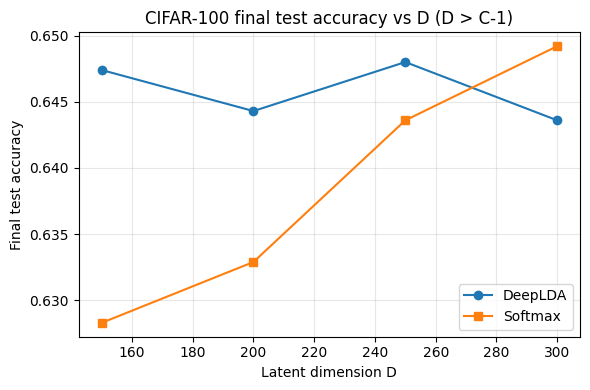

DeepLDA final test accuracy by D:
D=150: final test acc = 0.6474
D=200: final test acc = 0.6443
D=250: final test acc = 0.6480
D=300: final test acc = 0.6436
Softmax final test accuracy by D:
D=150: final test acc = 0.6283
D=200: final test acc = 0.6329
D=250: final test acc = 0.6436
D=300: final test acc = 0.6492


In [8]:
def extract_final(results):
    return [results[D]["final_test"] for D in D_values]

plt.figure(figsize=(6, 4))
plt.plot(D_values, extract_final(lda_results), marker='o', label='DeepLDA')
plt.plot(D_values, extract_final(softmax_results), marker='s', label='Softmax')
plt.xlabel('Latent dimension D')
plt.ylabel('Final test accuracy')
plt.title('CIFAR-100 final test accuracy vs D (D > C-1)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

for name, results in [('DeepLDA', lda_results), ('Softmax', softmax_results)]:
    print(f"{name} final test accuracy by D:")
    for D in D_values:
        print(f"D={D:3d}: final test acc = {results[D]['final_test']:.4f}")